## Simulator to run Markov Prediction over some datasets

In [1]:
import os
import numpy as np
import pandas as pd
from main.utils.predictor import TransitionMatrix, MarkovChainPredictor, get_state, min_max_scaler
from predict.settings import DATASET_DIR
import matplotlib.pyplot as plt

In [2]:
def read_data(data):
    return pd.read_csv(os.path.join(DATASET_DIR, f"{data}.csv"))

In [3]:
data = read_data("data")    

In [4]:
data.describe()

,No,year,month,day,hour,Rainfall,Dam cap.,Forestcov,Flo.inten
count,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000,256.000000
mean,128.500000,1982.078125,6.250000,5.843750,11.250000,711.265625,2872.843906,32.606070,3998.710938
std,74.045031,18.225864,4.153902,3.089356,6.882772,776.242770,205.379846,1.931889,7779.434143
min,1.000000,1951.000000,1.000000,1.000000,0.000000,0.300000,1825.116000,29.000000,0.000000
25%,64.750000,1966.000000,3.250000,3.000000,5.000000,95.100000,2841.980750,31.165706,0.000000
50%,128.500000,1982.000000,6.000000,6.000000,11.000000,408.500000,2842.044500,32.547124,0.000000
75%,192.250000,1998.000000,9.000000,8.250000,17.000000,946.325000,2842.108250,34.222119,878.250000
max,256.000000,2013.000000,12.000000,11.000000,23.000000,3229.300000,3346.624000,35.916000,25595.000000


In [5]:
data["WaterLevel"] = data["Dam cap."]

In [6]:
data["WaterLevel"].values.shape

(256,)

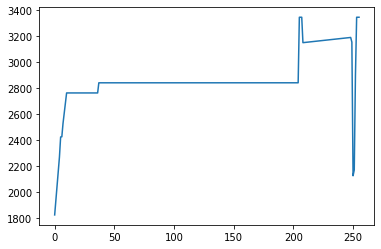

In [63]:
plt.plot(data["WaterLevel"])

In [7]:
max_height=3100.8

In [8]:
def split_test_train(data):
    length = data.shape[0]
    test = int(length * 1)
    test_data = data
    train_data = data
    return pd.DataFrame({'WaterLevel': test_data}), pd.DataFrame({'WaterLevel': train_data})

In [9]:
train_data, test_data = split_test_train(data["WaterLevel"].values)

In [10]:
transition_matrix = TransitionMatrix(train_data, max_height=max_height)

In [11]:
transition_matrix.generate()

array([[0.94871795, 0.05128205, 0.        ],
       [0.        , 0.98816568, 0.01183432],
       [0.0212766 , 0.        , 0.9787234 ]])

In [12]:
pd.DataFrame(transition_matrix.transitions)

,normal,almost_flooded,flooded
normal,37,2,0
almost_flooded,0,167,2
flooded,1,0,46


In [13]:
current_state = get_state(train_data["WaterLevel"].values[-1])

In [48]:
predictor = MarkovChainPredictor(transition_matrix.values, transition_matrix.states)
no_predictions = 16

In [49]:
predictor.next_state(current_state)

[0.94871795 0.05128205 0.        ]


'normal'

In [50]:
predictions = predictor.generate_states(current_state, no_predictions=no_predictions)

[0.94871795 0.05128205 0.        ]
[9.00065746e-01 9.93273656e-02 6.06888181e-04]
[0.85392144 0.14430911 0.00176945]
[0.81016825 0.18639215 0.0034396 ]
[0.76869434 0.22573342 0.00557224]
[0.72939267 0.26248224 0.00812508]
[0.6921608  0.29678069 0.01105851]
[0.65690066 0.32876392 0.01433542]
[0.62351845 0.35856044 0.01792111]
[0.59192445 0.38629243 0.02178313]
[0.56203282 0.41207602 0.02589116]
[0.5337615  0.43602157 0.03021693]
[0.50703203 0.45823394 0.03473403]
[0.48176941 0.4788127  0.0394179 ]
[0.45790196 0.4978524  0.04424564]
[0.43536121 0.5154428  0.04919599]


In [51]:
test_data["WaterLevel"] = min_max_scaler(test_data["WaterLevel"].values, max_height)
criteria = [test_data['WaterLevel'].le(0.75), 
            test_data['WaterLevel'].between(0.75, 0.98), 
            test_data['WaterLevel'].ge(0.98)]

values = ["normal", "almost_flooded", "flooded"]
test_data['state'] = np.select(criteria, values, 0)

In [52]:
difference = pd.DataFrame({"Prediction": predictions, "Actual_state": test_data["state"][:no_predictions]})

In [53]:
difference.query('Prediction != Actual_state').shape

(2, 2)

In [54]:
difference

,Prediction,Actual_state
0,normal,normal
1,normal,normal
2,normal,normal
3,normal,normal
4,normal,normal
5,normal,normal
6,normal,normal
7,normal,normal
8,normal,normal
9,normal,normal


In [49]:
accuracy = (difference.shape[0] - difference.query('Prediction != Actual_state').shape[0])/difference.shape[0]

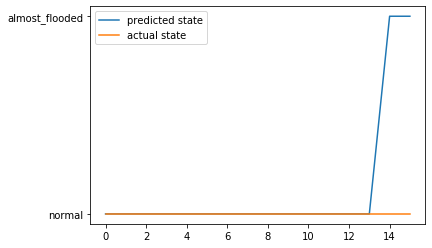

In [62]:
fig, ax = plt.subplots()
ax.plot(difference['Prediction'], label="predicted state")
ax.plot(difference['Actual_state'], label="actual state")
ax.legend()
plt.show()